# ¿Cómo construyo un modelo de predicción para los incumplimientos de préstamos de Lending Club?

## Introduccion

**Contexto comercial.** Hemos visto en el caso anterior lo que podemos hacer para determinar si un aspecto de la información personal (por ejemplo, si la información de ingresos está verificada) es importante al predecir el estado de incumplimiento. Este tipo de análisis ciertamente ayuda a simplificar el proceso de préstamo. Sin embargo, la pregunta más importante para todas las empresas de préstamos P2P, si un usuario incumplirá o no, aún no tiene respuesta. El algoritmo para predecir la probabilidad de incumplimiento es el núcleo de nuestro negocio y debemos construirlo con cuidado.

**Problema comercial.** Su tarea es **construir un modelo de clasificación para determinar si un usuario no pagará su préstamo o no**.

**Contexto analítico.** Como científico de datos, ahora debe concentrarse en perfeccionar el algoritmo de clasificación. Debe verificar cuantitativamente que el algoritmo funcionará para datos futuros. Además, debe expandir su conjunto de herramientas para no depender únicamente de la regresión logística, ya que tiene algunas deficiencias que otros tipos de modelos manejan mejor. El algoritmo de clasificación final se seleccionará a través de los procedimientos de evaluación del modelo que presentamos en los casos anteriores. Consideraremos modelos generados a partir de regresión logística, así como dos nuevos algoritmos: clasificadores Naive Bayes y Random Forest.

El caso está estructurado de la siguiente manera: usted: 1) generará un modelo de referencia a partir de una regresión logística; 2) introducir clasificadores Naive Bayes y Random Forest; 3) utilizar estos algoritmos para actualizar nuestro modelo; y finalmente 4) usar validación cruzada para seleccionar el mejor modelo.


## Evaluando el modelo de regresión logística

In [3]:
!pip install pydotplus

  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=73dca15f9f1172e1b8fd3e4b16ff973c38282ad3ad8acb8f91493a0fa653bfc5
  Stored in directory: c:\users\windows\appdata\local\pip\cache\wheels\89\e5\de\6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus


In [5]:
!pip install graphviz

In [1]:
import pandas as pd
import numpy  as np
from scipy.stats import chi2_contingency, norm
import statsmodels.api as sm
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from six import StringIO

#from sklearn.externals.six import StringIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy import interp
from statsmodels.formula.api import ols
import seaborn as sns

import pydotplus
from IPython.display import SVG
from graphviz import Source
from IPython.display import Image
from sympy import var, plot_implicit, Eq

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');

In [2]:
df = pd.read_csv("Lending_club_cleaned_2.csv", \
                 dtype = {"loan_status":"category", "annual_inc":"float", \
                          "verification_status":"category", "emp_length":"category", \
                          "home_ownership":"category", "int_rate":"object",\
                          "loan_amnt":"float", "purpose":"category",\
                          "term":"category", "grade":"category"})
df.int_rate = df.int_rate.str.rstrip("%").astype("float")

In [3]:
df.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000.0,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500.0,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400.0,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000.0,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000.0,other,60 months,B


Antes de continuar, revisemos los resultados y el código del modelo final que usamos en el caso anterior.

Optimization terminated successfully.
         Current function value: 0.378195
         Iterations 7


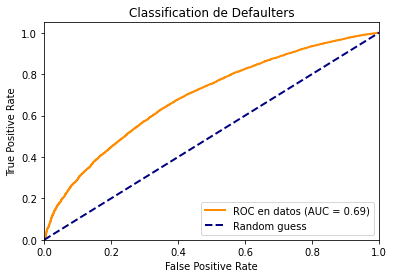

In [4]:
# design matrix for the data
df_log2 = pd.concat([(df.loan_amnt - df.loan_amnt.mean())/df.loan_amnt.std(),\
                     (df.int_rate - df.int_rate.mean())/df.int_rate.std(),\
                     (df.annual_inc - df.annual_inc.mean())/df.annual_inc.std(),\
                     pd.get_dummies(df.home_ownership, prefix="home", drop_first=True), \
                     pd.get_dummies(df.purpose, prefix="purpose", drop_first=True), \
                     pd.get_dummies(df.grade, prefix="grade",drop_first=True)], axis=1)
df_log2["verification_status"] = df.verification_status.cat.codes
df_log2["emp_length"] = df.emp_length.cat.codes
df_log2["term"] = df.term.cat.codes
df_log2["Intercept"] = 1

# Ajustar modelo de regresion logistica
logit_full1 = sm.Logit(df.loan_status.cat.codes, df_log2)
logit_full1_res = logit_full1.fit()

# plot el roc
predict_withvs = logit_full1_res.predict(df_log2)

roc_vs = roc_curve(df.loan_status.cat.codes, predict_withvs)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
lw = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange',
         lw=lw, label='ROC en datos (AUC = %0.2f)' % auc_vs)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification de Defaulters')
plt.legend(loc="lower right")
plt.show()

### Ejercicio 1

Genere la curva ROC de validación cruzada de 10 veces (el promedio de las 10 curvas ROC) y calcule el AUC promedio. Trace la curva ROC de validación cruzada, la curva ROC de datos de entrenamiento y la línea aleatoria en un solo gráfico.

In [5]:
# generar las curvas ROC y AUC por cross-validation 

def cv_roc(X, y, n_split):
    cv = StratifiedKFold(n_split)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        logit = sm.Logit(y.iloc[train], X.iloc[train])
        logit_res = logit.fit(disp=0)
        probas_ = logit_res.predict(X.iloc[test])
        # Calcular la curva ROC y el AUC
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

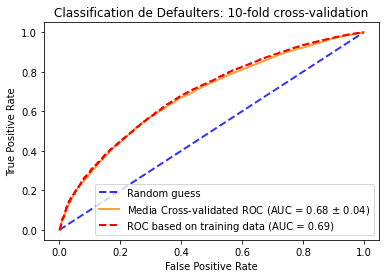

In [6]:
#hacer el plot
import warnings
warnings.filterwarnings("ignore")
tprs_vs, aucs_vs, mean_fpr_vs = cv_roc(df_log2, df.loan_status.cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange',
         label=r'Media Cross-validated ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_vs, std_auc_vs),
         lw=2, alpha=.8)

plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--',
         lw=lw, label='ROC based on training data (AUC = %0.2f)' % auc_vs)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Classification de Defaulters: 10-fold cross-validation')
plt.show()

Podemos ver que el AUC promedio es un poco más pequeño que el AUC calculado con datos de entrenamiento. La diferencia es pequeña, lo que indica que el problema de sobreajuste no es material en nuestro caso. La curva ROC de validación cruzada también está muy cerca de la curva ROC generada con datos de entrenamiento, lo que refuerza aún más nuestra opinión de que no tenemos un problema de sobreajuste.

Aunque la regresión logística es uno de los algoritmos de clasificación más utilizados, no es el único. Si la relación subyacente entre el logit de probabilidades y las covariables no es lineal, debemos considerar términos de orden superior de las covariables para que el modelo logístico sea válido. Hacerlo requiere mucho ajuste y experimentación. En tales casos, a menudo es mejor buscar un algoritmo de clasificación que no se base en una suposición específica sobre la relación entre la probabilidad del resultado y las covariables. Uno de esos modelos es el **clasificador Naive Bayes**.

## Naive Bayes classifier

### Teorema de condicional de Bayes

Naive Bayes depende del concepto de **probabilidad condicional (CP)**. La probabilidad condicional del evento $A$ dado el evento $B$ se define como la probabilidad de observar el evento $A$ siempre que el evento $B$ ya haya ocurrido. Numéricamente, esto significa:

$$
\text{CP($A$ given $B$)} = \frac{\text{P($A$ and $B$)}}{\text{P($B$)}}.
$$

Por supuesto, no hay nada especial en $A$ o $B$, por lo que podemos invertirlos en la identidad anterior para obtener:

$$
\text{CP($B$ given $A$)} = \frac{\text{P($B$ and $A$)}}{\text{P($A$)}}.
$$

Observe que los numeradores del lado derecho de ambas ecuaciones son idénticos. Por lo tanto, podemos igualarlos y sustituirlos en el resto de cada identidad para obtener:

$$
\text{CP($A$ given $B$)}\text{P($B$)} = \text{CP($B$ given $A$)}\text{P($A$)} \\
\rightarrow\text{CP($A$ given $B$)} = \frac{\text{CP($B$ given $A$)}\text{P($A$)}} {\text{P($B$)}} \\
$$

Este es el famoso **teorema de Bayes**, sobre el cual se construye el clasificador Naive Bayes.

### Ejercicio 2

Supongamos que sabemos que la probabilidad de que un cliente no tenga una fuente de ingresos verificada es 0.4, la probabilidad de incumplimiento es 0.5 y la probabilidad condicional de incumplimiento dado que el cliente no tiene una fuente de ingresos verificada es 0.8. ¿Cuál es la probabilidad de no tener ingresos verificados dado que el cliente es moroso?

Usando el teorema de Bayes:

$$
\text{CP(no verified income given defaulter)}=\frac{\text{CP(defaulter given no verified income)}\times \text{P(no verified income)}}{\text{P(defaulter)}} = \frac{0.8*0.4}{0.5}=\frac{16}{25}.
$$

### Introduccion al algoritmo

Recuerde que en la regresión logística, la principal cantidad de interés es la probabilidad de incumplimiento dados valores específicos para las covariables. Modelamos explícitamente esta probabilidad como una función lineal de covariables después de la transformación por la función logit.

El clasificador Naive Bayes tiene como objetivo estimar esta probabilidad desde una perspectiva diferente. A partir del teorema de Bayes, podemos expresar esta probabilidad condicional de la siguiente forma:

$$
\text{CP(defaulter given covariates=values)} = \frac{\text{CP(covariates=values given defaulter)P(defaulter)}}{\text{P(covariates=values)}}.
$$

Por lo tanto, si podemos estimar los valores del lado derecho, podemos obtener lo que queremos. Veamos cada una de estas cantidades:

1. $\text{P(defaulter)}$. Esta es la probabilidad de tener un moroso. Se puede estimar fácilmente como la proporción de morosos en el conjunto de datos.
2. $\text{P(covariates=values)}$. Esta es la probabilidad de tener un cliente cuyas covariables sean iguales a $\text{values}$. Esto también se puede estimar mediante proporciones, pero en realidad descubriremos que no es necesario estimar esta cantidad en absoluto (más sobre esto más adelante).
3. $\text{CP(covariates=values given defaulter)}$. Podemos estimar esto observando la proporción de morosos con covariables iguales a $\text{values}$. Pero si tenemos muchas covariables, el número de tales morosos podría ser extremadamente pequeño o incluso igual a cero. El principal desafío en la construcción de un clasificador Naive Bayes es estimar esta probabilidad particular.

Antes de proceder a hablar sobre el algoritmo para estimar $\text{CP(covariates=values given defaulter)}$, primero comprendamos por qué, cuando el número de covariables es grande, es difícil estimar $\text{CP(covariates=values given defaulter)}$ por proporciones directamente.

### Ejercicio 3

Supongamos que tenemos 10 covariables y que todas ellas son variables binarias. ¿Cuál es el número mínimo de muestras que necesitamos para que sea posible tener al menos una muestra para cada combinación posible de valores de estas covariables?

**Respuesta.** Solo necesitamos calcular cuántos valores posibles diferentes de covariables podemos tener cuando están presentes 10 covariables binarias. La respuesta es $2^{10}=1024$ porque cada covariable tiene dos valores diferentes y tenemos 10 covariables en total. Entonces, necesitamos tener al menos 1024 muestras para que sea posible estimar $\text{CP(covariates=values given defaulter)}$.

Este es un valor muy grande para solo 10 variables con muy pocos valores posibles. Si de repente tuviéramos 20 variables, este número sube a $10^6$ y se vuelve imposible de alcanzar.


### Porque el clasificador se llama "naive"? 

Como hemos visto en el Ejercicio 3, necesitamos muchas muestras para poder estimar $\text{CP(covariates=values given defaulter)}$ para todos los $\text{values}$ posibles usando proporciones observadas. Para sortear este problema, el clasificador Naive Bayes supone que *todas las covariables son independientes cuando están condicionadas por el resultado*. Es posible que esta suposición nunca sea cierta en el mundo real, razón por la cual el método se llama "ingenuo". No obstante, por lo general no obstaculiza severamente la herramienta en la práctica y brinda resultados bastante poderosos la mayor parte del tiempo.

En nuestro caso, el supuesto implica que dentro de los morosos/no morosos, todas las covariables se distribuyen de forma independiente:
$$
\text{CP(covariates=values given defaulter)} = \text{CP(covariate}_1\text{=value}_1\text{ given defaulter)}\times\cdots\times\text{CP(covariate}_p\text{=value}_p\text{ given defaulter)}
$$

Aquí asumimos que hay $p$ covariables en total. Veamos por qué reduce la cantidad de muestras requeridas para estimar proporciones.

### Ejercicio 4

Bajo las mismas suposiciones que en el ejercicio 3, más la suposición de independencia, ¿cuántas muestras necesitamos para estimar la probabilidad condicional $\text{CP(covariates=values given defaulter)}$?

**Respuesta.** Necesitamos estimar $p$ probabilidades condicionales más simples y cada una de ellas solo se refiere a una variable binaria, que tiene 2 resultados posibles. Entonces solo necesitamos al menos $2\times 10=20$ muestras ahora, que es *mucho* más pequeño que $1024$.

### Ejercicio 5

Con los datos disponibles, calcule $\text{CP(term give defaulter)}$ y $\text{CP(verfication_status give defaulter)}$ para todos los valores diferentes de `term` y `verification_status`.

In [7]:
# prob condicional del term y verification_status
df_default = df[df.loan_status=="Charged Off"]
# term
print("Probabilidad condicional de term dado defaulter:")
print((df_default.term.value_counts()/df_default.shape[0]));
print("")
# verification_status
print("Probabilidad condicional de verification_status dado defaulter:")
print(df_default.verification_status.value_counts()/df_default.shape[0]);

Probabilidad condicional de term dado defaulter:
 36 months    0.56489
 60 months    0.43511
Name: term, dtype: float64

Probabilidad condicional de verification_status dado defaulter:
Not Verified       0.376838
Verified           0.363419
Source Verified    0.259743
Name: verification_status, dtype: float64


Cuando una covariable es continua, la "proporción" de un valor dado suele ser cero debido a la naturaleza continua de la covariable. Para evitar esto, usamos la densidad de un valor de covariable para representar la probabilidad condicional. La densidad depende de la distribución de los datos generales; en el clasificador Naive Bayes, generalmente asumimos que los datos tienen una distribución normal (la segunda razón por la que es ingenuo). Luego encontramos los parámetros de una distribución normal que está más estrechamente alineado con la distribución observada de la covariable para obtener $\text{CP(covariate}\text{=value}\text{ given defaulter)}$.

Sabemos que una distribución normal está determinada únicamente por su media y su varianza, por lo que la distribución normal con una media igual a la media de la muestra y una varianza igual a la varianza de la muestra de la covariable es una buena estimación para usar. Una vez que obtengamos esta distribución normal, la densidad se puede calcular directamente para cualquier valor de covariable.

### Ejercicio 6

Encuentre la distribución normal que más se alinee con la distribución observada de `annual_inc` en morosos. Con base en esta distribución normal, calcule $\text{CP(annual_inc=10,000 given defaulter)}$. Funcion `pdf()` en `scipy.stats.norm` 
sirve para calcular la densidad de la distribucion normal dado un valor

In [8]:
mean_est = df_default.annual_inc.mean()
var_est = df_default.annual_inc.var()

# pdf toma la std del parametro de escala
print("CP(annual_inc=10,000 dado defaulter) =", norm.pdf(10000, loc = mean_est, scale = np.sqrt(var_est)))

CP(annual_inc=10,000 dado defaulter) = 4.473123137400813e-06


Una vez que hemos estimado todas estas probabilidades condicionales de una sola covariable, las multiplicamos para obtener nuestra estimación final de $\text{CP(covariates=values given defaulter)}$. Ahora, afirmamos que podemos usar el siguiente procedimiento para obtener $\text{CP(defaulter given covariates=values)}$:

1. Estimar $\text{P(defaulter)}$ and $\text{P(non-defaulter)}$.
2. Estimar $\text{CP(covariates=values given defaulter)}$ ay $\text{CP(covariates=values given non-defaulter)}$
3. Estimatar $\text{CP(defaulter given covariates=values)}$ con la siguiente ecuacion:

$$
\text{CP(defaulter given covariates=values)}=\frac{\text{CP(covariates=values given defaulter)}\text{P(defaulter)}}{\text{CP(covariates=values given defaulter)}\text{P(defaulter)}+\text{CP(covariates=values given non-defaulter)}\text{P(non-defaulter)}}
$$

### Ejercicio 7

Proporcione una justificación para la ecuación en el paso 3.

Como sólo se puede ser moroso o no moroso, tenemos

$$
\text{CP(defaulter given covariates=values)} + \text{CP(non-defaulter given covariates=values)} = 1.
$$

Con el teorema de Bayes tenemos:

$$
\text{CP(defaulter given covariates=values)} = \frac{\text{CP(covariates=values given defaulter)P(defaulter)}}{\text{P(covariates=values)}}\\
\text{CP(non-defaulter given covariates=values)} = \frac{\text{CP(covariates=values given non-defaulter)P(non-defaulter)}}{\text{P(covariates=values)}}
$$

Tomando la razón de las dos ecuaciones anteriores, tenemos

$$
\frac{\text{CP(defaulter given covariates=values)}}{\text{CP(non-defaulter given covariates=values)}} = \frac{\text{CP(covariates=values given defaulter)P(defaulter)}}{\text{CP(covariates=values given non-defaulter)P(non-defaulter)}}
$$

Combinando la ecuacion anterior con $\text{CP(defaulter given covariates=values)} + \text{CP(non-defaulter given covariates=values)} = 1$, obtenemos la ecuacion del paso 3.

Detengámonos un momento aquí y pensemos en lo que realmente hace el estimador Naive Bayes. Desde el paso 3, podemos ver que la probabilidad condicional de incumplimiento está determinada por los valores de las covariables a través de las probabilidades condicionales $\text{CP(covariates=values given defaulter)}$ y $\text{CP(covariates=values given non-defaulter)}$. 

La relación entre estas dos cantidades refleja cuán diferente es la distribución de las covariables en los morosos frente a los no morosos. Efectivamente, Naive Bayes está comparando la distribución de covariables en grupos de muestras con diferentes resultados. Esto nos proporciona una forma de preseleccionar las variables que deberían incluirse en el clasificador Naive Bayes.

Visualicemos las distribuciones de covariables en nuestro conjunto de datos, estratificados por estado de préstamo, para tener una idea de cuáles deben incluirse.

### Ejercicio 8

Usar la funcion `boxplot()` de `seaborn` para visualizar la distribución de las siguientes variables continuas: `loan_amnt`, `annual_inc` y `int_rate` en defaulters y non-defaulters. ¿Ve diferencias en las distribuciones entre morosos y no morosos? ¿Estos parecen satisfacer los supuestos del clasificador Naive Bayes? Si no, ¿qué debe hacer para que se ajusten?

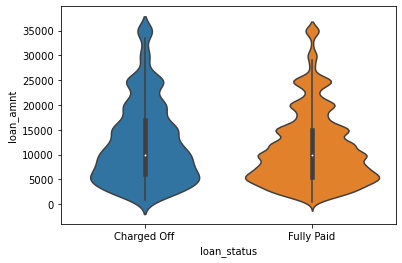

In [9]:
sns.violinplot(x = "loan_status", y = "loan_amnt", data = df);

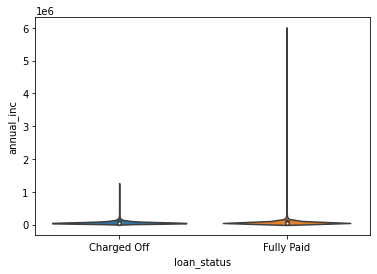

In [10]:
sns.violinplot(x = df.loan_status, y = df.annual_inc);

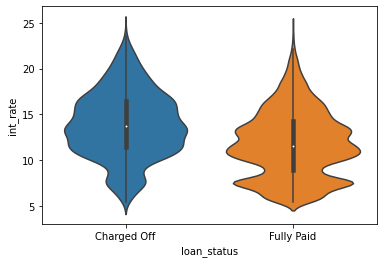

In [11]:
sns.violinplot(x = "loan_status", y = "int_rate", data = df );

Podemos ver que la distribución de la tasa de interés es diferente en los dos tipos de usuarios. La distribución del monto del préstamo también es diferente, donde los no morosos tienden a tener más préstamos con montos pequeños (alrededor de 5000). Las distribuciones de los ingresos anuales parecen estar muy sesgadas, así que apliquemos una transformación logarítmica para ver si podemos hacer que se vean más normales:

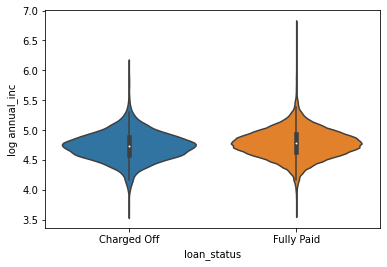

In [12]:
ax = sns.violinplot(x = df.loan_status, y = np.log10(df.annual_inc));
ax.set(ylabel='log annual_inc');

Esto es mucho mejor. La diferencia en los ingresos anuales no es muy grande, pero todavía podemos ver un ligero aumento en la media de los ingresos anuales en los no morosos en comparación con los morosos.

La distribución de `int_rate` es lo suficientemente cercana a la normal, pero la de `loan_amnt` parece un poco sesgada (aunque no se acerca al grado de `annual_inc`). Apliquemos una transformación de raíz cuadrada:

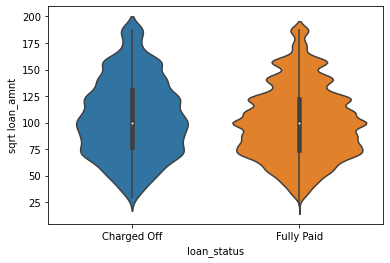

In [13]:
ax = sns.violinplot(x = df.loan_status, y = np.sqrt(df.loan_amnt));
ax.set(ylabel='sqrt loan_amnt');

Luce mejor!

Del ejercicio anterior, encontramos que necesitamos transformar `annual_inc` y `loan_amnt` para que la suposición de normalidad pueda satisfacerse aproximadamente. Usaremos las variables transformadas para construir el estimador Naive Bayes:

In [14]:
df["annual_inc_log"] = np.log10(df.annual_inc)
df["loan_amnt_sqrt"] = np.sqrt(df.loan_amnt)

## Implementando el clasificador

Hemos visto que para estimar el clasificador, necesitamos estimar la distribución normal que se puede ajustar a cada variable, luego usar esto para estimar las probabilidades que necesitamos. La siguiente función `nb_fit_con()` realizará la primera tarea:


In [15]:
"""
y es variable binaria de salida
X es una serie de variables numericas
"""
def nb_fit_con(y, X):
    y_code = y.cat.codes
    X_0 = X[y_code==0]
    X_1 = X[y_code==1]
    return [[np.mean(X_0), np.std(X_0)], [np.mean(X_1), np.std(X_1)]]

### Ejercicio 9

Escriba una función `nb_fit_dis` para estimar las probabilidades de cada nivel de una covariable discreta en morosos y no morosos. La función devuelve una lista de dos listas. El primer elemento contiene probabilidades en morosos. El segundo elemento contiene probabilidades en no morosos.

In [16]:
"""
y es variable binaria de salida
X es una serie de variables numericas
"""
def nb_fit_dis(y, X):
    y_code = y.cat.codes
    X_code = X.cat.codes
    X_nlvl = len(X.cat.categories)
    
    X_0 = X_code[y_code==0]
    X_1 = X_code[y_code==1]
    
    X_0_freq = [np.sum(X_0==x)/len(X_0) for x in range(X_nlvl)]
    X_1_freq = [np.sum(X_1==x)/len(X_1) for x in range(X_nlvl)]
    return [X_0_freq, X_1_freq]

La siguiente función utiliza las dos funciones de estimación que escribimos anteriormente para entrenar un clasificador Naive Bayes:

In [17]:
"""
y es variable binaria de salida
X es una serie de variables numericas
"""
def train_nb_classifier( y, X ):
    trained_model = {}
    for ind_col in X.columns:
        # verificar tipode dato
        if X[ind_col].dtype=="float":
            params_fit = nb_fit_con(y, X[ind_col])
        else:
            params_fit = nb_fit_dis(y, X[ind_col])
        trained_model[ind_col] = params_fit
    margin_p_0 = np.sum(y.cat.codes==0)/len(y)
    trained_model["margin_p"] = [margin_p_0, 1-margin_p_0]
    return trained_model

Una vez que se entrena el modelo, la siguiente función `predict_nb_classifier` predice la probabilidad de no incumplir para nuevas muestras:

In [18]:
"""
log de la densidad normal
"""
def log_dnorm( x, loc, scale ):
    return -(x-loc)**2/2/(scale**2) - np.log(scale) - 0.5*np.log(2*np.pi)

"""
prediccion
X_test: un dataframe de covariablespara la prediccion
        variables discretas tienen el mismo esquema de coding en el dataset
"""

def predict_nb_classifier( nb_fit, X_test ):
    pred_0_p = np.ones( X_test.shape[0] )*np.log(nb_fit["margin_p"][0])
    pred_1_p = np.ones( X_test.shape[0] )*np.log(nb_fit["margin_p"][1])
    
    for ind_col in X_test.columns:
        params = nb_fit[ind_col]
        if X_test[ind_col].dtype=="float":
            #incrementar la prob para outcome 0 de todas las muestras
            update_0 = log_dnorm( X_test[ind_col], loc = params[0][0], scale = params[0][1] )
            update_1 = log_dnorm( X_test[ind_col], loc = params[1][0], scale = params[1][1] )
        else:
            update_0 = [np.log(params[0][x]) for x in X_test[ind_col].cat.codes]
            update_1 = [np.log(params[1][x]) for x in X_test[ind_col].cat.codes]
        pred_0_p = pred_0_p + update_0
        pred_1_p = pred_1_p + update_1
    
    #calcular la probabilidad estimada del outcome=1
    #manejar casos raros e inf
    p_ratio = np.exp(pred_1_p-pred_0_p)
    p_1 = p_ratio/(1+p_ratio)
    p_1[p_ratio==np.Inf] = 1
    
    return p_1

### Ejercicio 10

Utilice las funciones `train_nb_classifier` y `predict_nb_classifier` para escribir una función para generar una curva ROC y calcular el AUC para el clasificador NB con validación cruzada `n_split` (consulte `cv_roc` para obtener una plantilla). La entrada debe ser `X`, la matriz de covariables, `y`, el vector de resultados y `n_split`, el número de folds. La salida es la misma tupla de 3 que la función `cv_roc`, donde el primer elemento es la lista de tasas positivas verdaderas en todos los pliegues `n_split`, el segundo elemento es una lista de AUC y el tercer elemento es una lista de medias falsas tasa positiva que se establece en `np.linspace (0, 1, 100)`. Utilice esta función en el clasificador NB con la covariable `term`, `verification_status` y `annual_inc`. Compare esto con el modelo logístico utilizando el mismo conjunto de covariables.

In [19]:
def cv_roc_nb(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        nb_trained = train_nb_classifier(y.iloc[train], X.iloc[train])
        probas_ = predict_nb_classifier( nb_trained, X.iloc[test] )
        # Calcular la curva  ROC y el AUC
        fpr, tpr, thresholds = roc_curve(y.iloc[test].cat.codes, probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

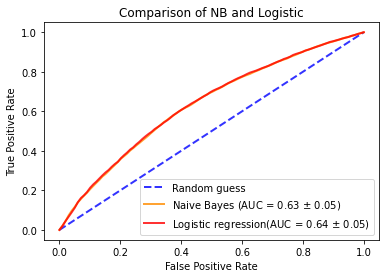

In [20]:
# ajustar el NB
tprs_nb, aucs_nb, mean_fpr_nb = cv_roc_nb( df[["term","verification_status","annual_inc_log"]], df.loan_status, 5)
# Regresion logistica
tprs_lgs, aucs_lgs, mean_fpr_lgs = cv_roc(df_log2[["Intercept","term","verification_status","annual_inc"]], df.loan_status.cat.codes, 5)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',label='Random guess', alpha=.8)

mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_nb[-1] = 1.0
mean_tpr_lgs = np.mean(tprs_lgs, axis=0)
mean_tpr_lgs[-1] = 1.0

mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
std_auc_nb = np.std(aucs_nb)
mean_auc_lgs = auc(mean_fpr_lgs, mean_tpr_lgs)
std_auc_lgs = np.std(aucs_lgs)

plt.plot(mean_fpr_nb, mean_tpr_nb, color='darkorange',
         label=r'Naive Bayes (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_nb, std_auc_nb),
         lw=2, alpha=.8)
plt.plot(mean_fpr_lgs, mean_tpr_lgs, color='red',
         label=r'Logistic regression(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lgs, std_auc_lgs),
         lw=2, alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Comparison of NB and Logistic')
plt.show()

Del ejercicio 10, podemos ver que el clasificador Naive Bayes tiene un AUC ligeramente más bajo que el modelo logístico correspondiente. Esto puede deberse a que estas tres covariables están altamente correlacionadas (como hemos visto en el caso anterior). Pero la diferencia no es muy grande. Teniendo en cuenta el hecho de que el clasificador Naive Bayes es muy fácil de implementar, aún podemos usarlo como clasificador preliminar.

### Cual usar? 

Al decidir qué modelo usar, el estándar de oro siempre debe incluir el rendimiento de la predicción; p.ej. AUC. Además del rendimiento, hay muchos otros factores que se deben tener en cuenta al elegir entre estos dos modelos:

1. Finalidad del análisis. Si lo que queremos es un clasificador rápido y sucio, Naive Bayes es el indicado, ya que la implementación es bastante sencilla y, en la mayoría de los casos, tiene un rendimiento similar al de un modelo de regresión logística.
2. Número de puntos de datos. En la era del big data es común encontrar conjuntos de datos con una enorme cantidad de muestras. Dado que la regresión logística se ajusta a través de una rutina de optimización, puede volverse muy lenta cuando la cantidad de datos es grande. El clasificador Naive Bayes no tiene este problema ya que solo calcula medias y varianzas y es extremadamente rápido incluso para grandes conjuntos de datos.
3. Número de covariables. A medida que aumenta el número de covariables, la carga computacional de la regresión logística crece mucho más rápido que de forma lineal. Naive Bayes no tiene este problema (se escala linealmente con el número de covariables) y debe considerarse como un fuerte candidato en este caso.

En nuestro caso, el conjunto de datos tiene menos de 40 000 muestras y solo 9 covariables, por lo que tanto la regresión logística como Naive Bayes están bien.


# Parte II

## Árboles de decisión y Random Forest

Analicemos ahora el **clasificador de árboles de decisión**. La siguiente figura muestra un ejemplo. Los nodos en la parte inferior del árbol se denominan nodos de hoja y todos los demás nodos se denominan nodos internos o nodos de rama. Cada nodo contiene una cantidad específica de muestras que se indica mediante `samples=`. Entre estas muestras, la proporción de muestras que son morosas y no morosas se indica mediante `value=`. Los valores de resultado mayoritarios se indican mediante `class=`.

Cuando desee predecir el default status de un punto de datos de muestra en particular, comience con el nodo superior. Este nodo interno le dice en qué dirección ir en función del valor de `annual_inc`. Siguiendo las instrucciones de los nodos internos, atraviesa el árbol hasta que encuentra un nodo de hoja. La etiqueta de resultado en ese nodo hoja es entonces el resultado previsto para esta muestra. Todo este proceso de predicción es muy parecido a lo que hacemos en nuestra vida diaria cuando tomamos una decisión (en función de la respuesta a una pregunta en particular, elegir qué pregunta responder a continuación y, después de suficientes respuestas, llegar a una conclusión).

In [28]:
 list(df.loan_status.unique())

['Fully Paid', 'Charged Off']

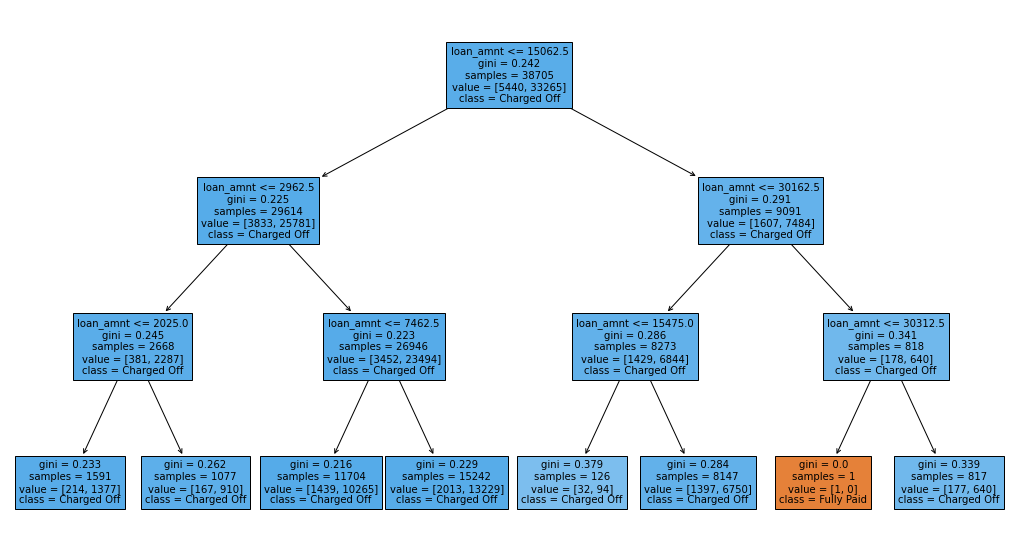

In [29]:
from sklearn import tree
clf = DecisionTreeClassifier(max_depth = 3)

# Train Decision Tree Classifer
clf = clf.fit(df[["loan_amnt"]], df.loan_status.cat.codes)
fig = plt.figure(figsize=(18,10))
_ = tree.plot_tree(clf,feature_names=['loan_amnt'],  
                   class_names= list(df.loan_status.unique()),
                   filled=True)

### Ejercicio 11

Suponga que tiene dos usuarios con `annual_inc` igual a 10,000 y 100,000,000 respectivamente. ¿Cuál es el default status previsto para estos dos usuarios, utilizando el árbol de decisión anterior?

**Respuesta.** Para el primer usuario, vamos a la izquierda, derecha y derecha. El nodo hoja contiene 2013 morosos y 13229 no morosos. Entonces predecimos que este usuario no será un moroso. Para el segundo usuario, vamos a la derecha, a la derecha y otra vez a la derecha. El resultado previsto para este usuario tampoco es moroso.

Podemos ver que el enfoque del árbol de decisiones no supone ninguna suposición sobre la relación entre el resultado y las covariables. Por lo tanto, es un algoritmo muy flexible que puede capturar una amplia gama de relaciones subyacentes entre el resultado y las covariables. Sin embargo, este algoritmo tiene muchos inconvenientes:

1. Debido a que es tan flexible, tiende a sobreajustarse. Cuando se aplica a un conjunto de validación independiente, el rendimiento suele disminuir significativamente. Este inconveniente realmente limita la aplicación de árboles de decisión.
2. Es difícil entrenar cuando el número de covariables es grande. En cada nodo interno, debe escanear una larga lista de posibles variables de división, lo que hace que el algoritmo sea complicado desde el punto de vista computacional. Sin embargo, este problema se ha mitigado con la potencia informática moderna.
3. Los árboles de decisión entrenados en el mismo conjunto de datos no siempre son los mismos. Este problema de inestabilidad ocurre porque es posible que el algoritmo no explore las covariables en el mismo orden cada vez. Como resultado, el árbol final puede variar mucho de una ejecución a otra.

### Ejercicio 12

Use la función `train_test_split` del paquete `sklearn`, seleccione aleatoriamente el 75 % de la muestra en nuestro conjunto de datos y entrene un árbol de decisión en estas muestras con la covariable `annual_inc`. Evalúe la precisión del árbol en el conjunto de entrenamiento y las muestras que no están incluidas en el conjunto de entrenamiento. ¿Ve un cambio significativo en la puntuación de precisión?

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df[["loan_amnt"]], \
                                                    df.loan_status.cat.codes, test_size = 0.25, \
                                                    random_state = 1)
clf_new = DecisionTreeClassifier()
clf_new = clf_new.fit(X_train, y_train)

y_pred_train = clf_new.predict(X_train)
y_pred_test = clf_new.predict(X_test)

print("Accuracy en training set:", accuracy_score(y_train, y_pred_train))
print("Accuracy en the other samples:", accuracy_score(y_test, y_pred_test))

Accuracy en training set: 0.8617886178861789
Accuracy en the other samples: 0.8524336054562365


**Respuesta.** Podemos ver que la precisión cae 0.1 en las otras muestras. Esto parece indicar que el problema de sobreajuste de nuestro árbol de decisión particular no es demasiado grave. Pero debemos tener en cuenta que la prevalencia de los no morosos en el conjunto de datos es mucho mayor que la de los morosos. Esto podría inflar la precisión de un clasificador mediocre. (Para ver un ejemplo de esto, considere un clasificador ingenuo que etiqueta a todos como no morosos. Este clasificador tendría razón la gran mayoría de las veces, pero difícilmente lo consideraríamos un clasificador matizado).

### Limites de decision en arboles de decision

El límite de decisión del árbol de decisión puede ser altamente no lineal. Por lo general, parece parches debido al hecho de que estamos dicotomizando el conjunto de datos en múltiples niveles. El siguiente es un ejemplo de un árbol construido con `annual_inc` y `loan_amnt`:

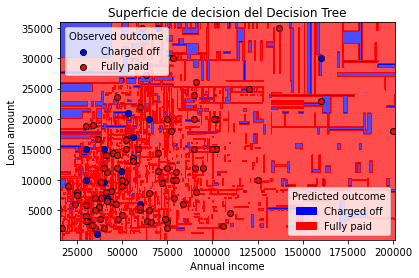

In [31]:
n_classes = 2
plot_colors = "br"

labels = ["Charged off", "Fully paid"]

clf = DecisionTreeClassifier().fit(df[["annual_inc","loan_amnt"]], df.loan_status.cat.codes)

# Graficar los decision boundary
plot_step = 100
viridis = cm.get_cmap('viridis', 2)
newcolors = viridis(np.linspace(0, 1, 2))
blue = np.array([0, 0, 1, 1])
red = np.array([1, 0, 0, 1])
newcolors[0, :] = blue
newcolors[1, :] = red
newcmp = ListedColormap(newcolors)

np.random.seed(0)
idx_plot = np.random.choice(df.shape[0], 100, replace = False )
df_plot = df.iloc[idx_plot]

x_min, x_max = df_plot.annual_inc.min() - 1000, df_plot.annual_inc.max() + 1000
y_min, y_max = df_plot.loan_amnt.min() - 1000, df_plot.loan_amnt.max() + 1000
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

fig, ax = plt.subplots()
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=newcmp, alpha = 0.7)

plt.xlabel("Annual income")
plt.ylabel("Loan amount")
plt.axis("tight");

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(df_plot.loan_status.cat.codes == i)
    plt.scatter(df_plot.iloc[idx].annual_inc, df_plot.iloc[idx].loan_amnt, c=color, 
                label=labels[i], edgecolors = "black")

legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='Charged off'),
                   Patch(facecolor='red', edgecolor='red',
                         label='Fully paid')]

plt.axis("tight")
plt.title("Superficie de decision del Decision Tree")
leg1 = ax.legend(loc='upper left', title = "Observed outcome")
ax.legend(handles=legend_elements, loc = 'lower right', title = 'Predicted outcome');
ax.add_artist(leg1);

### Random Forest para mejorar desempeño Decision Trees

**Random Forest** bien podría ser el algoritmo de aprendizaje automático más popular tanto para la clasificación como para la regresión. La idea detrás es construir una gran cantidad de árboles de decisión, luego usar un mecanismo de votación para producir una predicción final acordada por la mayoría de los árboles de decisión. Cuando entrenamos estos árboles individuales, también submuestreamos el conjunto de datos, así como las covariables que están disponibles para obtener la mayor validación cruzada integrada posible. Como resultado, el problema del sobreajuste y la estabilidad en un solo modelo de árbol de decisión se resuelve en gran medida. Ajustemos un Random forest con las covariables `term` y `annual_inc` y generemos su curva ROC usando los datos de entrenamiento:

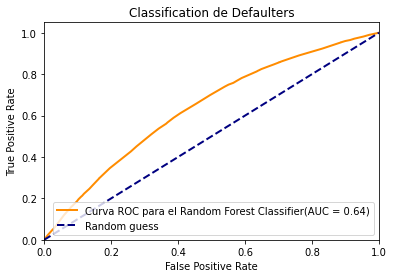

In [33]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf_rf.fit( df_log2[['annual_inc','term']], df.loan_status.cat.codes )
clf_rf_probas = clf_rf.predict_proba(df_log2[['annual_inc','term']])

roc_p = roc_curve(df.loan_status.cat.codes, clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
lw = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=lw, label='Curva ROC para el Random Forest Classifier(AUC = %0.2f)' % auc_p)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification de Defaulters')
plt.legend(loc="lower right")
plt.show()

### Ejercicio 13
Usar `cv_roc` como plantilla (los mismos argumentos de entrada más un argumento `algo` que determina el árbol de decisión o el Random Forest, la misma salida) para escribir una función `cv_roc_tree` que genera una ROC de validación cruzada de 5 veces para un modelo de árbol de decisión y un modelo de bosque aleatorio con las covariables `term` y `annual_inc`. ¿Ve un aumento significativo en el rendimiento de predicción del modelo de Random Forest en comparación con el modelo de árbol de decisión?


In [34]:
def cv_roc_tree(X, y, n_split, algo = 'Tree'):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        if algo=="Tree":
            clf = DecisionTreeClassifier()
        else:
            clf = RandomForestClassifier(n_estimators=100, max_depth = 3, random_state=0)
                
        clf = clf.fit(X.iloc[train], y.iloc[train])
        probas_ = clf.predict_proba( X.iloc[test] )
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

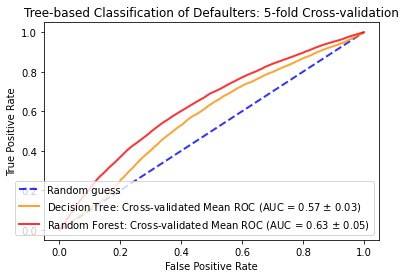

In [35]:
tprs_t, aucs_t, mean_fpr_t = cv_roc_tree( df_log2[["term","annual_inc"]], df.loan_status.cat.codes, 5)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree( df_log2[["term","annual_inc"]], df.loan_status.cat.codes, 5, algo = "forest")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
         label='Random guess', alpha=.8)

mean_tpr_t = np.mean(tprs_t, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_t[-1] = 1.0
mean_tpr_f[-1] = 1.0

mean_auc_t = auc(mean_fpr_t, mean_tpr_t)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
std_auc_t = np.std(aucs_t)
std_auc_f = np.std(aucs_f)

plt.plot(mean_fpr_t, mean_tpr_t, color='darkorange',
         label=r'Decision Tree: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_t, std_auc_t),
         lw=2, alpha=.8)
plt.plot(mean_fpr_f, mean_tpr_f, color='red',
         label=r'Random Forest: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_f, std_auc_f),
         lw=2, alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Tree-based Classification of Defaulters: 5-fold Cross-validation')
plt.show()

**Respuesta.** Podemos ver que hay un aumento en AUC usando el algoritmo de Random Forest. Con solo dos covariables, podemos lograr un aumento bastante significativo en el rendimiento. Esta diferencia probablemente sería más pronunciada con más variables.

## Eligiendo el modelo para predecir el lon_status

Hasta ahora hemos aprendido acerca de cuatro modelos de clasificación diferentes, sus fortalezas y debilidades, y cómo implementarlos. También estamos equipados con una poderosa herramienta de comparación de modelos, validación cruzada, para obtener una evaluación objetiva de un modelo de clasificación. Ahora construyamos los tres modelos (dejaremos de lado el árbol de decisión por ahora y solo usaremos bosque aleatorio ya que ambos pertenecen a la familia de modelos basados en árboles) usando todas nuestras covariables. Queremos comparar sus curvas ROC de validación cruzada y valores AUC para decidir cuál debe ser el que conforma el procedimiento de selección de usuarios para nuestra empresa:

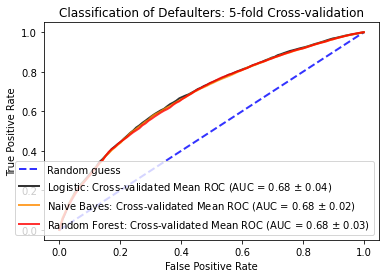

In [36]:
tprs_nb, aucs_nb, mean_fpr_nb = cv_roc_nb( df.drop(["loan_status","loan_amnt","annual_inc"], axis=1), df.loan_status, 5)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree( df_log2.drop("Intercept", axis=1), df.loan_status.cat.codes, 5, algo = "forest")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
         label='Random guess', alpha=.8)

mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_nb[-1] = 1.0
mean_tpr_f[-1] = 1.0

mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
std_auc_nb = np.std(aucs_nb)
std_auc_f = np.std(aucs_f)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='black',
         label=r'Logistic: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_vs, std_auc_vs),
         lw=2, alpha=.8)
plt.plot(mean_fpr_nb, mean_tpr_nb, color='darkorange',
         label=r'Naive Bayes: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_nb, std_auc_nb),
         lw=2, alpha=.8)
plt.plot(mean_fpr_f, mean_tpr_f, color='red',
         label=r'Random Forest: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_f, std_auc_f),
         lw=2, alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Classification of Defaulters: 5-fold Cross-validation')
plt.show()

Según los resultados anteriores, podemos elegir cualquiera de los tres modelos. En el futuro, si la cantidad de datos necesarios para procesar aumenta drásticamente, podemos priorizar el modelo Naive Bayes como una aproximación rápida al modelo logísticoo el RF. Lamentablemente, el RF parece tener un rendimiento idéntico con un tiempo de entrenamiento más largo. Esto se debe principalmente a que no ajustamos los parámetros en el algoritmo de RF, lo cual es un desafío en sí mismo. Hay situaciones en las que el RF es claramente el mejor modelo, pero eso está más allá del alcance de este caso.

## Conclusiones



En este caso, aprendimos sobre algunos nuevos modelos de clasificación y las ventajas y desventajas que tienen frente al modelo logístico estándar. Aprendimos que el clasificador Naive Bayes, aunque "ingenuo", generalmente no sufre mucho y, de hecho, es el más rápido de entrenar. Por otro lado, los modelos basados en árboles y, en particular, el Random Forest pueden capturar muchas relaciones e interacciones no lineales en nuestros datos, pero son mucho más lentos de entrenar. Luego usamos la validación cruzada para seleccionar el modelo que tiene el mejor rendimiento entre los tipos de modelos que hemos aprendido hasta ahora.

## Para recordar

La regresión logística, Naive Bayes y los modelos basados en árboles (árboles de decisión y Random Forest) son excelentes modelos de clasificación que tienen sus fortalezas y debilidades. La validación cruzada es una forma especialmente buena de evaluar la efectividad de estos modelos uno al lado del otro.